<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/Cfar_10_Model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:

# torch- Our deep learning framework
import torch
import torch.nn as nn
from torchvision import datasets
import urllib.request
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split,SubsetRandomSampler
from torch import optim
import torch.nn.functional as F
import math
from sklearn.model_selection import KFold
import numpy as np
import requests
import tarfile
import os
import torchvision
from sklearn.model_selection import KFold
import torch.utils.data
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.is_available())  # Should print True if GPU is available
# Check if CUDA is available before getting device name
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))  # Prints the name of the GPU using get_device_name
else:
    print("CUDA is not available. No GPU device found.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
Tesla T4


In [3]:

batch_size = 128
epochs = 10
seed = 42 # so I can reproduce the results
epsilon = 1e-8
grad_eps = 1e-3
clip_factor = 0.1
learning_rate = 1e-4
image_height = 28
image_width = 28
input_channels = 3
number_classes= 10
num_folds = 10

In [4]:

def create_train_val_loaders(train_dataset, val_ratio=0.2, batch_size=batch_size, num_workers=2, seed=seed):
    """
    Splits the training data into train and validation sets, creates DataLoaders for train and validation.

    Args:
        train_dataset (torch.utils.data.Dataset): The original training dataset.
        val_ratio (float): The ratio of the training data to use for validation.
        batch_size (int): The batch size for the DataLoaders.
        num_workers (int): The number of workers for the DataLoaders.
        seed (int): The random seed for consistent splits.

    Returns:
        tuple: (train_loader, val_loader)
    """

    total_train_size = len(train_dataset)
    val_size = int(val_ratio * total_train_size)
    train_size = total_train_size - val_size

    generator = torch.Generator().manual_seed(seed)
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader


In [5]:

# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(
    root='data',
    train=True,
    transform=transform,
    download=True,
)

test_data = datasets.CIFAR10(
    root='data',
    train=False,
    transform=transform
)

100%|██████████| 170M/170M [00:03<00:00, 42.7MB/s]


Extracting data/cifar-10-python.tar.gz to data


In [12]:
print(len(train_data))

50000


In [6]:


# Create DataLoaders
train_loader, val_loader = create_train_val_loaders(train_data)
test_loader = torch.utils.data.DataLoader(test_data,
            batch_size=batch_size,
   shuffle=True,

num_workers=1, pin_memory=True) # Pin memory for data)

In [7]:


print(train_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [8]:

print(test_data)

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [9]:
class PUConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(PUConv2d, self).__init__()
        self.weights_u = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for positive inputs
        self.weights_v = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for indicator function
        self.stride = stride
        self.padding = padding  # Store the padding value
        # Initialize weights (important!)
        nn.init.kaiming_uniform_(self.weights_u, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weights_v, a=math.sqrt(5))

    def forward(self, x):
        # Apply padding before unfolding
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))

        batch_size, in_channels, in_height, in_width = x.size()
        kernel_size = self.weights_u.shape[2]
        out_channels = self.weights_u.shape[0]

        out_height = (in_height - kernel_size) // self.stride + 1
        out_width = (in_width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded = F.unfold(x, kernel_size=kernel_size, stride=self.stride)
        unfolded = unfolded.view(batch_size, in_channels * kernel_size * kernel_size, out_height * out_width)

        # Weights for positive input component
        weights_u_reshaped = self.weights_u.view(out_channels, -1)

        # Logarithm of absolute value
        log_abs_unfolded = torch.log(torch.abs(unfolded) + epsilon)  # Add small constant for numerical stability

        # Compute the exponential part (corresponding to Eq. 3)
        exp_term = torch.exp(torch.einsum("oc,bcp->bop", weights_u_reshaped, log_abs_unfolded))

        # Weights for indicator function
        weights_v_reshaped = self.weights_v.view(out_channels, -1)

        # Indicator function (vectorized)
        indicator = (unfolded < 0).float()

        # Compute the cosine term (corresponding to Eq. 4)
        cosine_term = torch.cos(math.pi * torch.einsum("oc,bcp->bop", weights_v_reshaped, indicator)).view(batch_size, out_channels, out_height, out_width)

        # Combine the terms
        output = exp_term.view(batch_size, out_channels, out_height, out_width) * cosine_term

        return output

In [10]:
class SigmaPUConv2d(nn.Module):
    def __init__(self, in_channels= input_channels, num_classes=number_classes, image_height=image_height, image_width=image_width):
        super(SigmaPUConv2d, self).__init__()
        self.product_conv1 = PUConv2d(in_channels, 16, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels, 16, 3)
        self.bn1_prod = nn.BatchNorm2d(16)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.25)

        self.product_conv2 = PUConv2d(32, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.bn2_prod = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.25)

        self.product_conv3 = PUConv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.bn3_prod = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.25)

        self.product_conv4 = PUConv2d(128, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.bn4_prod = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(0.25)

        self.bn_final = nn.BatchNorm2d(256)

        self.image_height = image_height
        self.image_width = image_width

        self.fc_input_size = self._calculate_fc_input_size()

        self.fc_model = nn.Sequential(
            nn.Linear( self.fc_input_size, 128),  # Use fc_input_size here
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
            )
    def _conv_block(self, x, conv, bn, pool=True):
        x = conv(x)
        x = bn(x)
        x = F.relu(x)
        if pool:
            x = F.max_pool2d(x, 2)
        return x

    def _calculate_fc_input_size(self):
        dummy_input = torch.randn(1, input_channels, self.image_height, self.image_width) #Correct input size

        y = self._conv_block(dummy_input, self.product_conv1, self.bn1_prod, pool=False)
        z = self._conv_block(dummy_input, self.conv1, self.bn1, pool=False)
        combined_features = torch.cat((y, z), dim=1)

        y2 = self._conv_block(combined_features, self.product_conv2, self.bn2_prod, pool=False)
        z2 = self._conv_block(combined_features, self.conv2, self.bn2, pool=False)
        combined_features2 = torch.cat((y2, z2), dim=1)

        y3 = self._conv_block(combined_features2, self.product_conv3, self.bn3_prod, pool=False)
        z3 = self._conv_block(combined_features2, self.conv3, self.bn3, pool=False)
        combined_features3 = torch.cat((y3, z3), dim=1)

        y4 = self._conv_block(combined_features3, self.product_conv4, self.bn4_prod)
        z4 = self._conv_block(combined_features3, self.conv4, self.bn4)
        combined_features4 = torch.cat((y4, z4), dim=1)

        combined_features4 = self.bn_final(combined_features4)
        combined_features4 = F.relu(combined_features4)
        combined_features4 = F.adaptive_avg_pool2d(combined_features4, (7, 7)) # Apply adaptive pooling before calculating size

        return combined_features4.view(1, -1).size(1)

    def forward(self, x, return_feature_maps=False):
        y = self._conv_block(x, self.product_conv1, self.bn1_prod, pool=False)
        z = self._conv_block(x, self.conv1, self.bn1, pool=False)
        combined_features = torch.cat((y, z), dim=1)

        y2 = self._conv_block(combined_features, self.product_conv2, self.bn2_prod, pool=False)
        z2 = self._conv_block(combined_features, self.conv2, self.bn2, pool=False)
        combined_features2 = torch.cat((y2, z2), dim=1)

        y3 = self._conv_block(combined_features2, self.product_conv3, self.bn3_prod, pool=False)
        z3 = self._conv_block(combined_features2, self.conv3, self.bn3, pool=False)
        combined_features3 = torch.cat((y3, z3), dim=1)

        y4 = self._conv_block(combined_features3, self.product_conv4, self.bn4_prod)
        z4 = self._conv_block(combined_features3, self.conv4, self.bn4)
        combined_features4 = torch.cat((y4, z4), dim=1)

        combined_features4 = self.bn_final(combined_features4)
        combined_features4 = F.relu(combined_features4)

        # Use adaptive pooling to get a fixed output size
        combined_features4 = F.adaptive_avg_pool2d(combined_features4, (7, 7))

        combined_features4 = combined_features4.view(combined_features4.size(0), -1)



        x = self.fc_model(combined_features4)
        output = F.log_softmax(x, dim=1)

        if return_feature_maps:
            return output, y2, z2, combined_features3
        else:
            return output

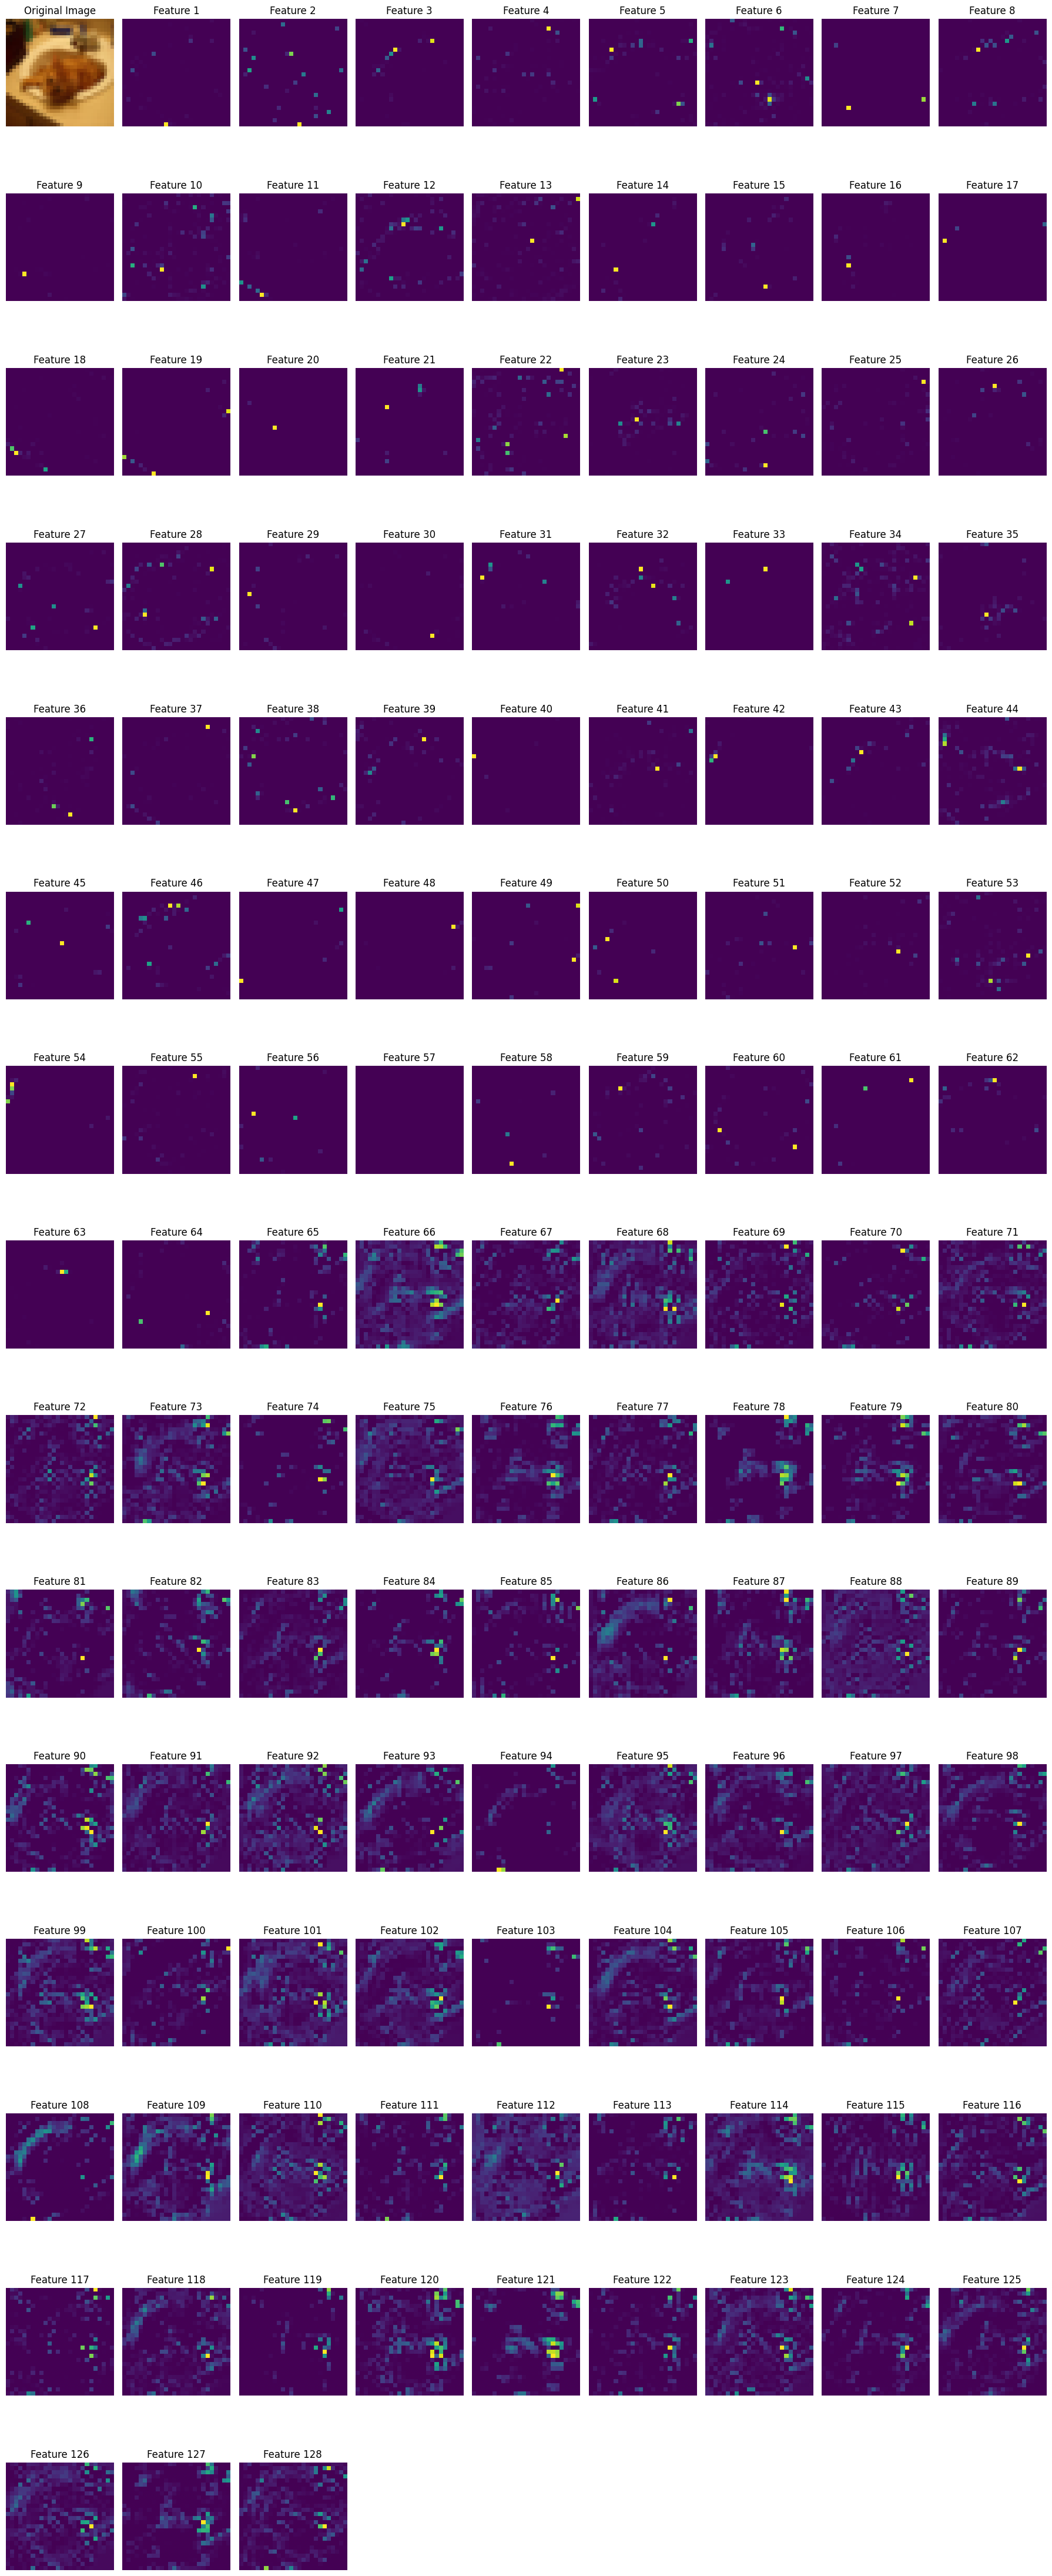

In [ ]:
# %%
# Assuming train_loader is already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SigmaPUConv2d().to(device)
model.eval()

data_iter = iter(train_loader)
image, label = next(data_iter)
image = image.to(device)

output, prod_conv_features, conv1_features, combined_features3 = model(image, return_feature_maps=True)

# Limit the number of features to display
num_features_to_display = combined_features3.shape[1]

# Calculate the subplot grid dimensions based on num_features_to_display
num_cols = min(9, num_features_to_display)  # Maximum 9 columns
num_rows = (num_features_to_display + num_cols - 1) // num_cols  # Calculate rows

plt.figure(figsize=(18, 3 * num_rows))  # Adjust figure height for more rows

plt.subplot(num_rows, num_cols, 1)  # Subplot for the original image
plt.imshow(np.transpose(image[0].cpu().numpy(), (1, 2, 0)) * 0.5 + 0.5)
plt.title("Original Image")
plt.axis('off')

# Loop through the features to display
for i in range(num_features_to_display):
    # Calculate the subplot index, ensuring it stays within the valid range
    subplot_index = i + 2
    plt.subplot(num_rows, num_cols, subplot_index)  # Use calculated grid
    plt.imshow(combined_features3[0, i].detach().cpu().numpy(), cmap='viridis')
    plt.title(f'Feature {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()
# %%

--- Epoch 1 ---
	Train loss: 2.0915, acc: 0.2281%
	Val loss: 1.9381, acc: 0.3328%
--- Epoch 2 ---
	Train loss: 1.7265, acc: 0.3696%
	Val loss: 1.7176, acc: 0.4095%
--- Epoch 3 ---
	Train loss: 1.5647, acc: 0.4323%
	Val loss: 1.6644, acc: 0.4472%
--- Epoch 4 ---
	Train loss: 1.4752, acc: 0.4678%
	Val loss: 1.5709, acc: 0.4659%
--- Epoch 5 ---
	Train loss: 1.4054, acc: 0.4970%
	Val loss: 1.4563, acc: 0.4932%
--- Epoch 6 ---
	Train loss: 1.3484, acc: 0.5182%
	Val loss: 1.6852, acc: 0.4821%
--- Epoch 7 ---
	Train loss: 1.3023, acc: 0.5335%
	Val loss: 1.6350, acc: 0.4816%
--- Epoch 8 ---
	Train loss: 1.2564, acc: 0.5517%
	Val loss: 1.5266, acc: 0.5041%
--- Epoch 9 ---
	Train loss: 1.2253, acc: 0.5647%
	Val loss: 1.5056, acc: 0.4990%
--- Epoch 10 ---
	Train loss: 1.2043, acc: 0.5718%
	Val loss: 1.4439, acc: 0.5188%


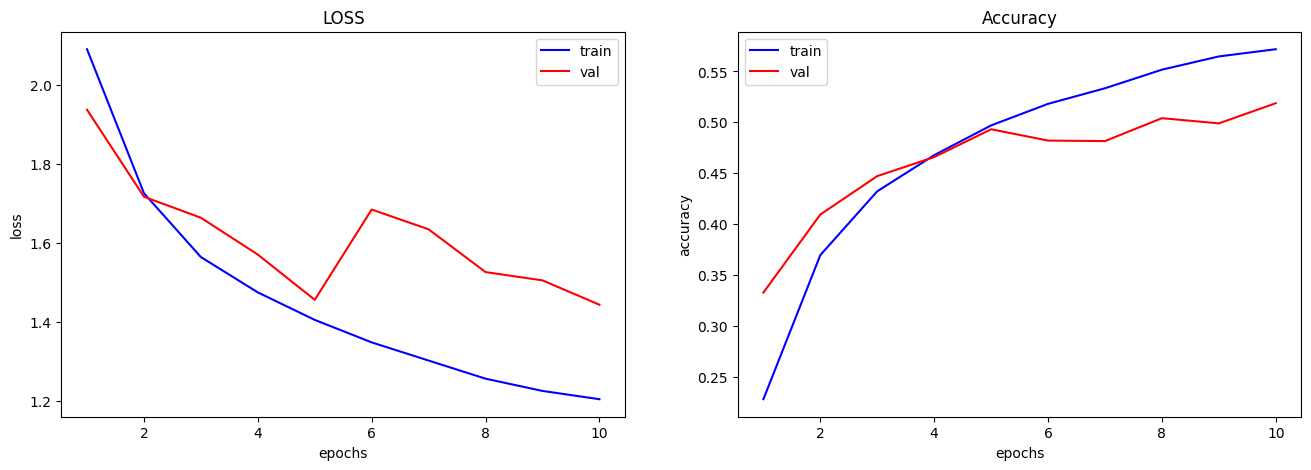

In [28]:

model = SigmaPUConv2d().to(device)
# loss function
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#Alternative Adaptive Gradient Clipping (Norm Based)
def adaptive_clip_grad_norm(parameters, clip_factor=clip_factor, eps=grad_eps):
    if not isinstance(parameters, torch.Tensor):
        parameters = list(filter(lambda p: p.grad is not None, parameters))
    if not parameters:
        return

    device = parameters[0].device
    total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach()).to(device) for p in parameters]))
    clip_coef = (clip_factor * total_norm) / (total_norm + eps)
    if clip_coef < 1:
        for p in parameters:
            p.grad.detach().mul_(clip_coef.to(p.grad.device))

####TRAIN
def train(epoch):

    # Setting model in training mode.
    model.train()

    train_loss = 0
    train_acc = 0
    scaler = torch.amp.GradScaler()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        #clear gradient
        optimizer.zero_grad()

        #FP (make a prediction)
        output = model(data.float())

        # calculating the loss
        loss = loss_func(output, target)

        # BP, Computing the gradient of the loss w.r.t the parameters of the model
        loss.backward()

        # a single step of optimization, update parameters
        adaptive_clip_grad_norm(model.parameters())
        optimizer.step()

        train_loss += loss.item()

        _, pred = output.max(1)
        train_acc += target.eq(pred).sum().item()

    train_acc /= len(train_loader.dataset)
    train_loss /= (batch_idx + 1) # Average per batch

    return train_loss, train_acc
###TEST

def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(val_loader.dataset)
    return val_loss, val_acc

###PLOT
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [1]:

# --- Data Loading and Preprocessing ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform,
    download=True,
)

# --- K-Fold Cross-Validation ---
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

for fold, (train_ids, val_ids) in enumerate(kfold.split(full_dataset)):
    print(f"FOLD {fold + 1}")

    # --- Create DataLoaders ---
    train_subset = Subset(full_dataset, train_ids)
    val_subset = Subset(full_dataset, val_ids)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # --- Model, Optimizer, Loss ---
    model = SigmaPUConv2d().to(device)  # Or replace with your SigmaPUConv2d
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # --- Training Loop ---
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        print(f"  Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%")

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        print(f"  Epoch {epoch + 1}, Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

print("Cross-validation complete.")


NameError: name 'transforms' is not defined